# Energy Label Transition Model: Overview and Analysis Plan

This notebook implements an **agent-based model (ABM)** of a housing market to study the dynamics of **residential energy label upgrades** over time.  
The model simulates interactions between **houses** and **owners**, capturing how financial status, personal preferences, and neighbourhood effects influence decisions to **stay, move, or upgrade** houses.  

---


## Model Components

1. **Houses (`House` agents)**  
   - Passive containers of information about **current energy label** (A+ to G) and **market value**.  
   - Can be vacant or occupied by a single owner.  

2. **Homeowners (`Owner` agents)**  
   - Decide annually among four options:  
     1. Stay in the current house  
     2. Upgrade the current house  
     3. Move to a different house  
     4. Move and upgrade simultaneously  
   - Decisions are based on:  
     - Available budget (`financial_status`)  
     - Preferences for energy label vs. market value  
     - Neighbourhood effects (`chillness`)  
     - Expected satisfaction for each option  

3. **City Model (`City`)**  
   - Houses are placed on a grid.  
   - Tracks agent actions and collects data on:  
     - Energy label transitions  
     - Moves and upgrades  
     - Average city-level energy label  

---

## Helper Functions

Several **helper functions** are included to:  
- Convert energy labels to numeric values for calculations  
- Compute upgrade costs and feasible energy label transitions  
- Estimate satisfaction from house characteristics  
- Facilitate analysis and visualization of model outcomes  

---


## Code Workflow

The notebook/code follows a structured workflow:

1. **Model Setup and Execution**  
   - Initialize a city with a specified number of houses and owners.  
   - Assign initial energy labels, financial status, and preferences.  
   - Run the simulation for multiple years (1 step = 1 year).  

2. **Data Collection**  
   - Collect both **agent-level** and **model-level** data using Mesa's `DataCollector`.  
   - Track metrics such as number of transitions, moves, and average energy label over time.  

3. **Verification**  
   - Perform **trace validation** by following a single owner to check expected behavior.  
   - Perform **invariant checks** to ensure logical consistency, e.g., each house has at most one owner, counters match sums.  

4. **Visualization and Analysis**  
   - Time series plots for cumulative transitions and average labels.  
   - Energy label distribution comparisons (initial vs. final).  
   - Grid-based animations of occupancy and energy labels over time.  

5. **Batch Experiments and Sensitivity Analysis**  
   - Explore the effect of varying parameters such as:  
     - Financial status  
     - Market value distribution  
     - Energy label preference  
     - Importance of neighbours  
   - Generate summary tables, ranking of parameter combinations, and visualizations.  

6. **Mini-Batch Experimental Design**  
   - Run factorial experiments with a small number of scenarios.  
   - Compare outcomes across scenarios for key indicators (moves, transitions, average energy label).  
   - Explore relationships between **social cohesion** of owners and **house energy labels**.  

---


## Purpose of the Model

The purpose of this model is to explore how individual homeowner preferences, financial constraints, and neighbourhood characteristics jointly shape:

- Energy label transitions of the housing stock
- Residential mobility patterns
- The distribution of sustainability outcomes over time

The model is designed as an **exploratory tool**, allowing analysis of emergent dynamics rather than point predictions. It is particularly suited for investigating:
- Trade-offs between upgrading and relocating
- The role of neighbourhood spillovers in sustainability transitions
- Distributional outcomes across heterogeneous households



### Imports

Required libraries for running the agent-based housing model.


In [24]:
# Core Mesa library for agent-based modeling
import mesa

# Numerical and data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns

# Random
import random
import gc

# Type hints for better code documentation
from typing import Dict, List, Tuple

# Print Mesa version to confirm correct installation
print(f"Mesa version: {mesa.__version__}")
print("Required: Mesa 3.0.3 or higher")   


Mesa version: 3.3.1
Required: Mesa 3.0.3 or higher


### Helper Functions

A set of helper functions for energy label and house calculations.  
They convert between energy labels and numeric values, compute upgrade costs, and estimate house satisfaction or potential upgrades based on financial status and preferences.


In [25]:
def label_to_numeric(label: str) -> int:
    """Convert energy label to numeric value (G=0 to A+=7)."""
    # Dictionary mapping letter labels to numbers for calculations
    mapping = {"G": 0, "F": 1, "E": 2, "D": 3, "C": 4, "B": 5, "A": 6, "A+": 7}
    return mapping.get(label, 0)  # Return 0 if label not found


def numeric_to_label(value: float) -> str:
    """Convert numeric value back to energy label string."""
    # Dictionary mapping numbers back to letter labels
    mapping = {0: "G", 1: "F", 2: "E", 3: "D", 4: "C", 5: "B", 6: "A", 7: "A+"}
    rounded = int(round(value))  # Round to nearest integer
    rounded = max(0, min(7, rounded))  # Clamp to valid range [0, 7]
    return mapping[rounded] # This returns the corresponding label


def calculate_transition_cost(current_label: str, target_label: str) -> float:
    """Calculate cost to transition from current to target label.
    
    Simple linear cost model: 10,000€ per label step improvement.
    Example: D→B costs 20,000€ (2 steps × 10,000€)
    """
    # Calculate how many label steps need to be improved
    gap = label_to_numeric(target_label) - label_to_numeric(current_label)
    
    # If already at or above target, no cost needed
    if gap <= 0:
        return 0.0
    
    # Linear cost: €10,000 per label step
    return gap * 10000

# ------------------------------------------------------------------
# New functions
# ------------------------------------------------------------------

def calculate_house_satisfaction(current_label: str, market_value: float, energy_label_pref: float, market_value_pref: float) -> float:
    
    "Return house satisfaction as a weighted sum of energy label quality and market value."
    
    return (
        label_to_numeric(current_label) * energy_label_pref
        + market_value * market_value_pref
    )

def calculate_max_label_upgrade(financial_status: int, current_label: str) -> str:
    
    "Return the highest energy label affordable given the owner's financial status."
    
    label_steps = max(financial_status, 0) // 10000
    max_label = min(label_to_numeric(current_label) + label_steps, 7)
    return numeric_to_label(max_label)


def calculate_max_value_upgrade(financial_status: int, market_value_current: float) -> float:
    
    "Return the maximum market value of a house the owner can afford when moving."
    
    value_steps = max(financial_status, 0) // 10000
    return market_value_current + value_steps


def calculate_neighbour_chillness(self) -> float:
    
    "Return the average chillness of neighbouring owners (0.5 if no neighbours)."
    
    x, y = self.house.pos

    neighbours = self.model.grid.get_neighbors(
        (x, y), moore=True, include_center=False
    )

    chillness_values = [
        agent.chillness for agent in neighbours
        if isinstance(agent, Owner)
    ]

    return (
        sum(chillness_values) / len(chillness_values)
        if chillness_values else 0.5
    )


### House Agent

Defines the `House` agent, a passive container for energy efficiency information.  
Each house stores its current energy label and the ID of its owner (if any). Houses do not take actions each simulation step.


In [26]:
class House(mesa.Agent):
    """House agent - passive container for energy efficiency information."""

    def __init__(self, model, current_label: str):
        super().__init__(model)  # Initialize Mesa Agent. Note that mesa will assign a unique ID to each agent instance
        self.current_label = current_label  # Energy label (A+ to G)
        self.owner_id = None  # ID of owner living here (None if vacant)
    
    def step(self):
        """Houses are passive - no actions needed each time step."""
        pass

# Owner Agent

Defines the `Owner` agent, representing homeowners who annually decide whether to stay, upgrade, move, or move and upgrade.  
Decisions are based on financial status, personal preferences (energy label vs. market value), neighbourhood effects, and expected satisfaction across options.  
Includes methods for evaluating all options, applying upgrades, and executing the agent's annual decision step.


In [27]:
class Owner(mesa.Agent):
    """
    Homeowner agent who annually decides whether to:
    - stay in the current house,
    - upgrade the current house’s energy label,
    - move to another house,
    - or move and upgrade simultaneously.

    Decisions are based on:
    - financial constraints,
    - preferences for energy label and market value,
    - neighbourhood effects,
    - and a comparison of expected satisfaction across options.
    """

    def __init__(
        self,
        model,
        financial_status: float,
        energy_label_pref: float,
        market_value_pref: float,
        chillness: float
    ):
        """
        Initialize a homeowner agent.

        Parameters
        ----------
        model : mesa.Model
            Reference to the overarching Mesa model.
        financial_status : float
            Available budget for upgrading or moving.
        energy_label_pref : float
            Weight assigned to energy label quality in satisfaction.
        market_value_pref : float
            Weight assigned to house market value in satisfaction.
        chillness : float
            Individual sensitivity to neighbourhood characteristics.
        """
        super().__init__(model)

        self.financial_status = financial_status
        self.energy_label_pref = energy_label_pref
        self.market_value_pref = market_value_pref
        self.chillness = chillness

        # Housing state
        self.house = None  # Assigned externally
        self.has_transitioned = 0
        self.has_moved = 0
        self.has_moved_and_transitioned = 0

    # ------------------------------------------------------------------
    # 1. Current situation evaluation
    # ------------------------------------------------------------------

    def update_neighbour_and_current_satisfaction(self):
        """
        Compute the owner's current housing satisfaction.

        This combines:
        - intrinsic satisfaction from the house (energy label & value)
        - a neighbourhood effect based on surrounding agents
        """
        # Measure neighbourhood effect (normalized around 0)
        self.neighbour_chillness = calculate_neighbour_chillness(self) - 0.5

        # Current satisfaction of staying put
        self.curr_house_sat = (
            calculate_house_satisfaction(
                self.house.current_label,
                self.house.market_value,
                self.energy_label_pref,
                self.market_value_pref
            )
            + self.model.importance_of_neighbours * self.neighbour_chillness
        )

    # ------------------------------------------------------------------
    # 2. Upgrade-in-place evaluation
    # ------------------------------------------------------------------

    def evaluate_upgrade_option(self):
        """
        Evaluate upgrading the current house without moving.

        Determines:
        - maximum feasible energy label upgrade,
        - associated cost,
        - resulting satisfaction after upgrading.
        """
        self.max_label_upgrade = calculate_max_label_upgrade(
            self.financial_status,
            self.house.current_label
        )

        self.upgrade_cost = calculate_transition_cost(
            self.house.current_label,
            self.max_label_upgrade
        )

        self.pot_house_sat_upg = (
            calculate_house_satisfaction(
                self.max_label_upgrade,
                self.house.market_value,
                self.energy_label_pref,
                self.market_value_pref
            )
            + self.model.importance_of_neighbours * self.neighbour_chillness
        )

    def apply_upgrade(self):
        """
        Apply an in-place energy label upgrade.

        This method performs *state changes* only and is called
        once the upgrade option has been selected as optimal.
        """
        self.financial_status -= self.upgrade_cost
        self.house.current_label = self.max_label_upgrade
        self.curr_house_sat = self.pot_house_sat_upg
        self.has_transitioned += 1

    # ------------------------------------------------------------------
    # 3. Move and move+upgrade evaluations
    # ------------------------------------------------------------------

    def evaluate_move_options(self):
        """
        Evaluate all feasible moving options.

        This includes:
        - moving without upgrading,
        - moving and upgrading after purchase.

        Only houses within the owner's financial reach are considered.
        """
        max_value = calculate_max_value_upgrade(
            self.financial_status,
            self.house.market_value
        )

        # Select unoccupied houses within budget
        empty_houses = self.model.agents_by_type[House].select(
            lambda h: h.owner_id is None and h.market_value <= max_value
        )

        self.evaluate_move_only(empty_houses)
        self.evaluate_move_and_upgrade(empty_houses)

    def evaluate_move_only(self, houses):
        """
        Evaluate satisfaction from moving to another house
        without performing any upgrade.
        """
        self.pot_house_sat_move = float("-inf")
        self.best_house_move = None

        for house in houses:
            sat = calculate_house_satisfaction(
                house.current_label,
                house.market_value,
                self.energy_label_pref,
                self.market_value_pref
            )

            if sat > self.pot_house_sat_move:
                self.pot_house_sat_move = sat
                self.best_house_move = house

    def evaluate_move_and_upgrade(self, houses):
        """
        Evaluate satisfaction from moving to another house
        and upgrading it using remaining financial resources.
        """
        self.pot_house_sat_move_and_upg = float("-inf")
        self.best_house_move_and_upg = None

        for house in houses:
            # Remaining budget after selling current house and buying new one
            rest_income = (
                self.financial_status
                + self.house.market_value * 10000
                - house.market_value * 10000
            )

            pot_label_upgrade = calculate_max_label_upgrade(
                rest_income,
                house.current_label
            )

            sat = calculate_house_satisfaction(
                pot_label_upgrade,
                house.market_value,
                self.energy_label_pref,
                self.market_value_pref
            )

            if sat > self.pot_house_sat_move_and_upg:
                self.pot_house_sat_move_and_upg = sat
                self.best_house_move_and_upg = house

    # ------------------------------------------------------------------
    # 4. Decision logic
    # ------------------------------------------------------------------

    def make_decision(self):
        """
        Compare all evaluated options and select the one
        with the highest expected satisfaction.

        Possible outcomes:
        - do nothing,
        - upgrade current house,
        - signal intention to move,
        - signal intention to move and upgrade.
        """
        max_sat = max(
            self.curr_house_sat,
            self.pot_house_sat_upg,
            self.pot_house_sat_move,
            self.pot_house_sat_move_and_upg
        )

        # Reset intentions each step
        self.wants_to_move = False
        self.wants_to_move_and_upgrade = False

        # If current situation is best, do nothing
        if self.house is None or max_sat == self.curr_house_sat:
            return

        if max_sat == self.pot_house_sat_upg:
            self.apply_upgrade()

        elif max_sat == self.pot_house_sat_move:
            self.wants_to_move = True

        elif max_sat == self.pot_house_sat_move_and_upg:
            self.wants_to_move_and_upgrade = True

    # ------------------------------------------------------------------
    # 5. Annual step
    # ------------------------------------------------------------------

    def step(self):
        """
        Annual decision step for the homeowner agent.

        Execution order:
        1. Evaluate current satisfaction and neighbourhood effects
        2. Evaluate upgrading current house
        3. Evaluate moving options
        4. Select and apply the best option
        """
        self.update_neighbour_and_current_satisfaction()
        self.evaluate_upgrade_option()
        self.evaluate_move_options()
        self.make_decision()



### City Model

Defines the `City` model, representing a housing market on a spatial grid.  
The model includes houses with energy labels and market values, owners who make annual decisions, and a relocation mechanism to resolve competing bids for empty houses.  
One model step represents one year, during which owners evaluate options, relocations are resolved, and data is collected for analysis.


In [28]:
class City(mesa.Model):
    """
    City model representing a housing market on a spatial grid.

    The model contains:
    - Houses with energy labels and market values
    - Owners who occupy houses and make annual decisions
    - A relocation mechanism that resolves competing bids for empty houses

    One model step represents one year.
    """

    # ------------------------------------------------------------------
    # 1. Model initialization
    # ------------------------------------------------------------------

    def __init__(
        self,
        num_houses: int = 50,
        num_owners: int = 40,
        grid_size: int = 10,
        financial_status_mean: float = 30000,
        financial_status_std: float = 5000,
        label_distribution: Dict[str, float] = None,
        market_value_distribution: tuple = (0.5, 0.5),
        average_energy_label_preference: float = 0.5,
        variance_energy_label_preference: float = 0.2,
        importance_of_neighbours: float = 1.0,
        seed: int = None
    ):
        """
        Initialize the city, populate it with houses and owners,
        and set up data collection.
        """
        super().__init__(seed=seed)

        self.validate_inputs(num_houses, num_owners)

        # Store parameters
        self.num_houses = num_houses
        self.num_owners = num_owners
        self.grid_size = grid_size
        self.financial_status_mean = financial_status_mean
        self.financial_status_std = financial_status_std
        self.market_value_distribution = market_value_distribution
        self.average_energy_label_preference = average_energy_label_preference
        self.variance_energy_label_preference = variance_energy_label_preference
        self.importance_of_neighbours = importance_of_neighbours

        # Energy label distribution
        self.label_distribution = self.init_label_distribution(label_distribution)

        # Spatial environment
        self.grid = mesa.space.MultiGrid(grid_size, grid_size, torus=False)

        # Populate model
        self.create_houses()
        self.create_owners()
        self.assign_houses_to_owners()

        # Data collection
        self.setup_data_collection()
        self.datacollector.collect(self)

    def validate_inputs(self, num_houses, num_owners):
        """Ensure model parameters are internally consistent."""
        if num_owners > num_houses:
            raise ValueError(
                f"Cannot have more owners ({num_owners}) than houses ({num_houses})!"
            )

    def init_label_distribution(self, label_distribution):
        """
        Initialize the energy label distribution.

        Defaults to a housing stock with many low-efficiency houses
        and few high-efficiency ones.
        """
        if label_distribution is None:
            return {
                "G": 0.05, "F": 0.10, "E": 0.20, "D": 0.30,
                "C": 0.20, "B": 0.10, "A": 0.04, "A+": 0.01
            }
        return label_distribution

    # ------------------------------------------------------------------
    # 2. Spatial valuation
    # ------------------------------------------------------------------

    def compute_location_value(self, pos):
        """
        Compute a normalized location value ∈ [0, 1]
        based on Euclidean distance to the grid center.
        """
        x, y = pos
        cx = (self.grid_size - 1) / 2
        cy = (self.grid_size - 1) / 2

        dist = ((x - cx)**2 + (y - cy)**2)**0.5
        max_dist = ((cx)**2 + (cy)**2)**0.5

        return 1 - (dist / max_dist)

    # ------------------------------------------------------------------
    # 3. Agent creation
    # ------------------------------------------------------------------

    def create_houses(self):
        """
        Create houses, assign energy labels and market values,
        and place them at random grid locations.
        """
        labels = list(self.label_distribution.keys())
        probs = list(self.label_distribution.values())

        total_cells = self.grid_size * self.grid_size
        if self.num_houses > total_cells:
            raise ValueError(
                f"Cannot place {self.num_houses} houses on {total_cells} grid cells."
            )

        all_positions = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size)]
        selected_positions = self.random.sample(all_positions, self.num_houses)

        for pos in selected_positions:
            label = self.random.choices(labels, weights=probs, k=1)[0]

            house = House(self, label)
            house.location_value = self.compute_location_value(pos)

            # Market value combines location and energy efficiency
            house.market_value = (
                house.location_value * self.market_value_distribution[0]
                + label_to_numeric(house.current_label) / 7 * self.market_value_distribution[1]
            ) * 7

            self.grid.place_agent(house, pos)

    def create_owners(self):
        """
        Create owner agents and place them in randomly selected houses.
        """
        house_positions = self.agents_by_type[House].get("pos")

        selected_positions = self.random.sample(house_positions, self.num_owners)

        for pos in selected_positions:
            financial_status = max(
                0,
                self.random.gauss(
                    self.financial_status_mean,
                    self.financial_status_std
                )
            )

            energy_label_pref = min(
                max(
                    self.random.gauss(
                        self.average_energy_label_preference,
                        self.variance_energy_label_preference
                    ),
                    0.0
                ),
                1.0
            )

            owner = Owner(
                self,
                financial_status,
                energy_label_pref,
                1 - energy_label_pref,
                self.random.random()
            )

            self.grid.place_agent(owner, pos)

    def assign_houses_to_owners(self):
        """
        Link each owner to the house located at the same grid position.
        """
        for owner in self.agents_by_type[Owner]:
            cellmates = self.grid.get_cell_list_contents([owner.pos])

            if len(cellmates) != 2:
                raise ValueError(
                    f"Expected one house and one owner at {owner.pos}, found {len(cellmates)}"
                )

            house = cellmates[0] if cellmates[0] is not owner else cellmates[1]
            owner.house = house
            house.owner_id = owner.unique_id

    # ------------------------------------------------------------------
    # 4. Data collection & indicators
    # ------------------------------------------------------------------

    def setup_data_collection(self):
        """Configure Mesa DataCollector for model- and agent-level metrics."""
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Num_Transitioned": self.count_transitions,
                "Num_Movings": self.count_moves,
                "Num_Moving_and_Transitioned": self.count_moves_and_transitions,
                "Avg_Label_Numeric": lambda m: label_to_numeric(m.get_current_avg_label()),
                "Avg_Label": self.get_current_avg_label
            },
            agent_reporters={
                "Agent_Type": lambda a: type(a).__name__,
                "Financial_Status": lambda a: getattr(a, 'financial_status', None),
                "Has_Transitioned": lambda a: getattr(a, 'has_transitioned', None),
                "Has_Moved": lambda a: getattr(a, 'has_moved', None),
                "Has_Moved_and_Transitioned": lambda a: getattr(a, 'has_moved_and_transitioned', None),
                "Neighbour_chillness": lambda a: getattr(a, 'neighbour_chillness', None),
                "Owner_House_Label": lambda a: a.house.current_label if isinstance(a, Owner) and a.house else None,
                "House_Label": lambda a: a.current_label if isinstance(a, House) else None
            }
        )

    # ------------------------------------------------------------------
    # 5. Aggregate statistics
    # ------------------------------------------------------------------

    def get_current_avg_label(self) -> str:
        """Return the average energy label of occupied houses."""
        occupied = self.agents_by_type[House].select(lambda h: h.owner_id is not None)

        if len(occupied) == 0:
            return "D"

        avg = sum(label_to_numeric(h.current_label) for h in occupied) / len(occupied)
        return numeric_to_label(avg)

    def count_transitions(self):
        return sum(o.has_transitioned for o in self.agents_by_type[Owner])

    def count_moves(self):
        return sum(o.has_moved for o in self.agents_by_type[Owner])

    def count_moves_and_transitions(self):
        return sum(o.has_moved_and_transitioned for o in self.agents_by_type[Owner])

    # ------------------------------------------------------------------
    # 6. Relocation mechanism
    # ------------------------------------------------------------------

    def relocation_step(self):
        """
        Resolve all owner relocation intentions.

        Process:
        1. Collect interest per empty house
        2. Resolve competition by financial strength
        3. Execute relocation and possible upgrade
        """
        interest = self.collect_move_interest()
        self.resolve_relocations(interest)

    def collect_move_interest(self):
        """Build a mapping from empty houses to interested owners."""
        interest = {
            house.unique_id: []
            for house in self.agents_by_type[House].select(lambda h: h.owner_id is None)
        }

        for owner in self.agents_by_type[Owner]:
            if owner.wants_to_move and owner.best_house_move:
                interest[owner.best_house_move.unique_id].append(owner)

            if owner.wants_to_move_and_upgrade and owner.best_house_move_and_upg:
                interest[owner.best_house_move_and_upg.unique_id].append(owner)

        return interest

    def resolve_relocations(self, interest):
        """Assign each empty house to the strongest competing owner."""
        for house_id, candidates in interest.items():
            if not candidates:
                continue

            winner = max(
                candidates,
                key=lambda o: o.financial_status + o.house.market_value * 10000
            )

            house = next(h for h in self.agents_by_type[House] if h.unique_id == house_id)
            self.execute_move(winner, house)

    def execute_move(self, owner, new_house):
        """
        Move an owner to a new house and handle financial transfers
        and optional upgrading.
        """
        old_house = owner.house
        old_house.owner_id = None

        new_house.owner_id = owner.unique_id
        owner.house = new_house

        value_diff = new_house.market_value - old_house.market_value
        owner.financial_status -= value_diff * 10000

        if owner.wants_to_move_and_upgrade:
            self.execute_post_move_upgrade(owner)
        else:
            owner.has_moved += 1

        owner.best_house_move = None
        owner.best_house_move_and_upg = None

    def execute_post_move_upgrade(self, owner):
        """Upgrade the house after relocation if desired."""
        label_upgrade = calculate_max_label_upgrade(
            owner.financial_status,
            owner.house.current_label
        )

        cost = calculate_transition_cost(owner.house.current_label, label_upgrade)

        owner.financial_status -= cost
        owner.house.current_label = label_upgrade
        owner.has_moved_and_transitioned += 1

    # ------------------------------------------------------------------
    # 7. Model step
    # ------------------------------------------------------------------

    def step(self):
        """
        Execute one yearly simulation step.

        Timeline:
        1. Owners evaluate options and signal intentions
        2. Relocations are resolved
        3. Model data is collected
        """
        self.agents_by_type[Owner].do("step")
        self.relocation_step()
        self.datacollector.collect(self)


### Original Base Model: Data Collection & Visualization

This section demonstrates running the original `City` model with default or user-defined parameters, collecting data, and visualizing results.  

It includes:  
- Model creation and initialization  
- Simulation execution over multiple years  
- Collection of model- and agent-level data using Mesa's `DataCollector`  
- Time series plots of cumulative transitions and average energy labels  
- Comparison of initial vs. final energy label distributions  
- Grid-based animation of house occupancy and energy labels over time  
- Batch experiments exploring the effect of financial status on transitions and average labels, including error-bar visualizations  


#### Model creation, initialization and simulation

In [29]:
# Create and run model
print("Creating model...")
model = City(
    num_houses=50,
    num_owners=40,
    grid_size=10,
    financial_status_mean=30000,
    financial_status_std=5000,
    seed=42
) # note that you can decide to not define the values for the parameters. In this case, default values defined in the model class will be used

# Store initial label counts for comparison later
initial_label_counts = {}
for house in model.agents_by_type[House]:
    label = house.current_label
    initial_label_counts[label] = initial_label_counts.get(label, 0) + 1

print("\n" + "="*60)
print("INITIAL STATE (Year 0)")
print("="*60)
print(f"Number of houses:       {model.num_houses}")
print(f"Number of owners:       {model.num_owners}")
print(f"Grid size:              {model.grid_size} × {model.grid_size}")
print(f"Initial avg label:      {model.get_current_avg_label()}")
print("="*60)

# Run simulation
print("\nRunning simulation for 30 years...")
num_years = 30

for year in range(num_years):
    model.step()
    if (year + 1) % 10 == 0:
        print(f"  Year {year + 1}: Avg label = {model.get_current_avg_label()}, "
              f"Transitions = {model.count_transitions()}")

print("\n" + "="*60)
print(f"FINAL STATE (Year {num_years})")
print("="*60)
print(f"Final avg label:        {model.get_current_avg_label()}")
print(f"Total transitions:      {model.count_transitions()} / {model.num_owners} "
      f"({model.count_transitions()/model.num_owners*100:.1f}%)")
print("="*60)

Creating model...

INITIAL STATE (Year 0)
Number of houses:       50
Number of owners:       40
Grid size:              10 × 10
Initial avg label:      D

Running simulation for 30 years...
  Year 10: Avg label = A, Transitions = 19
  Year 20: Avg label = A, Transitions = 19
  Year 30: Avg label = A, Transitions = 19

FINAL STATE (Year 30)
Final avg label:        A
Total transitions:      19 / 40 (47.5%)


#### Collection of model- and agent-level data

In [30]:
# Get model-level data (one row per year)
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,Num_Transitioned,Num_Movings,Num_Moving_and_Transitioned,Avg_Label_Numeric,Avg_Label
0,0,0,0,3,D
1,2,0,5,3,D
2,7,0,8,4,C
3,17,1,10,5,B
4,17,1,12,5,B
5,18,1,14,5,B
6,19,1,19,6,A
7,19,1,20,6,A
8,19,1,20,6,A
9,19,1,20,6,A


In [31]:
# Get agent-level data (one row per owner per year)
agent_data = model.datacollector.get_agent_vars_dataframe()
house_data = agent_data[agent_data['Agent_Type'] == 'House'].iloc[:, 12:]
house_data

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), ...]

[1550 rows x 0 columns]

In [32]:
# View just the owner data
owner_data = agent_data[agent_data['Agent_Type'] == 'Owner'].iloc[:, :12]
owner_data

Agent_Type  Financial_Status  Has_Transitioned  Has_Moved  \
Step AgentID                                                             
0    51           Owner      38339.690893               0.0        0.0   
     52           Owner      35497.403014               0.0        0.0   
     53           Owner      26673.818848               0.0        0.0   
     54           Owner      36534.693063               0.0        0.0   
     55           Owner      35891.786484               0.0        0.0   
...                 ...               ...               ...        ...   
30   86           Owner        758.319727               0.0        0.0   
     87           Owner        349.861513               1.0        0.0   
     88           Owner       1245.574083               0.0        0.0   
     89           Owner        964.259044               0.0        0.0   
     90           Owner        311.738531               0.0        0.0   

              Has_Moved_and_Transitioned  Neighbour_chillness  \
Step AgentID                                                    
0    51                              0.0                  NaN   
     52                              0.0                  NaN   
     53                              0.0                  NaN   
     54                              0.0                  NaN   
     55                              0.0                  NaN   
...                                  ...                  ...   
30   86                              1.0             0.079603   
     87                              0.0             0.257008   
     88                              1.0             0.145775   
     89                              1.0             0.038872   
     90                              1.0            -0.006184   

             Owner_House_Label House_Label  
Step AgentID                                
0    51                      E        None  
     52                      D        None  
     53                      E        None  
     54                      C        None  
     55                      D        None  
...                        ...         ...  
30   86                      D        None  
     87                      B        None  
     88                      B        None  
     89                      B        None  
     90                      B        None  

[1240 rows x 8 columns]

#### Time series plots of cumulative transitions and average energy labels

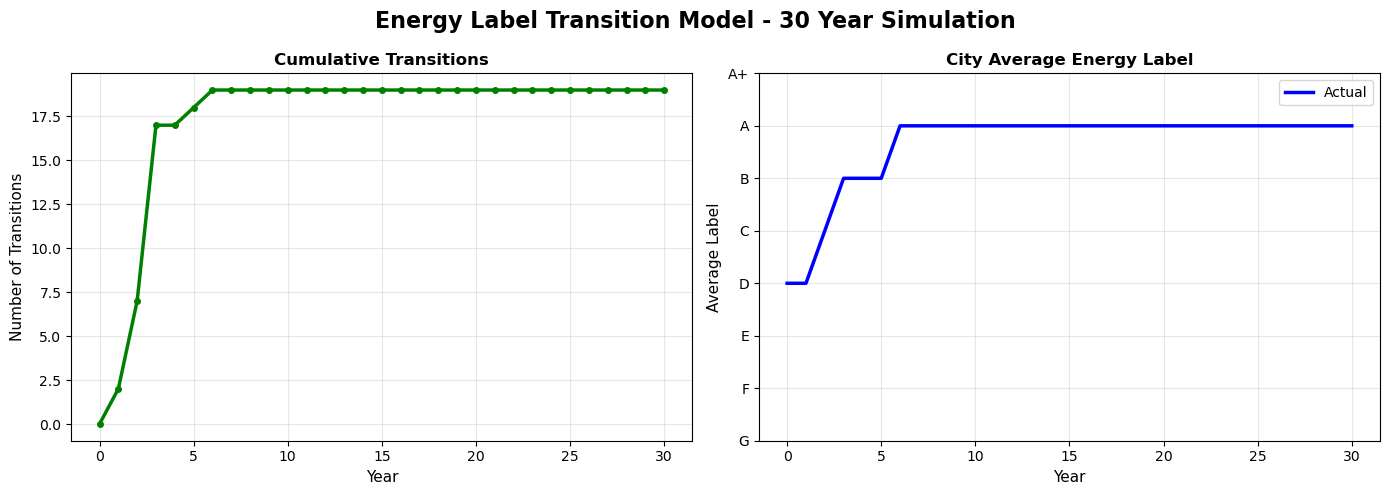

In [33]:
# Visualize time series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Energy Label Transition Model - 30 Year Simulation', 
             fontsize=16, fontweight='bold')

# Plot 1: Cumulative transitions
axes[0].plot(model_data.index, model_data['Num_Transitioned'], 
             linewidth=2.5, color='green', marker='o', markersize=4)
axes[0].set_xlabel('Year', fontsize=11)
axes[0].set_ylabel('Number of Transitions', fontsize=11)
axes[0].set_title('Cumulative Transitions', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Average label
axes[1].plot(model_data.index, model_data['Avg_Label_Numeric'], 
             linewidth=2.5, color='blue', label='Actual')
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Average Label', fontsize=11)
axes[1].set_title('City Average Energy Label', fontsize=12, fontweight='bold')
axes[1].set_yticks(range(8))
axes[1].set_yticklabels(['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A+'])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Comparison of initial vs. final energy label distributions

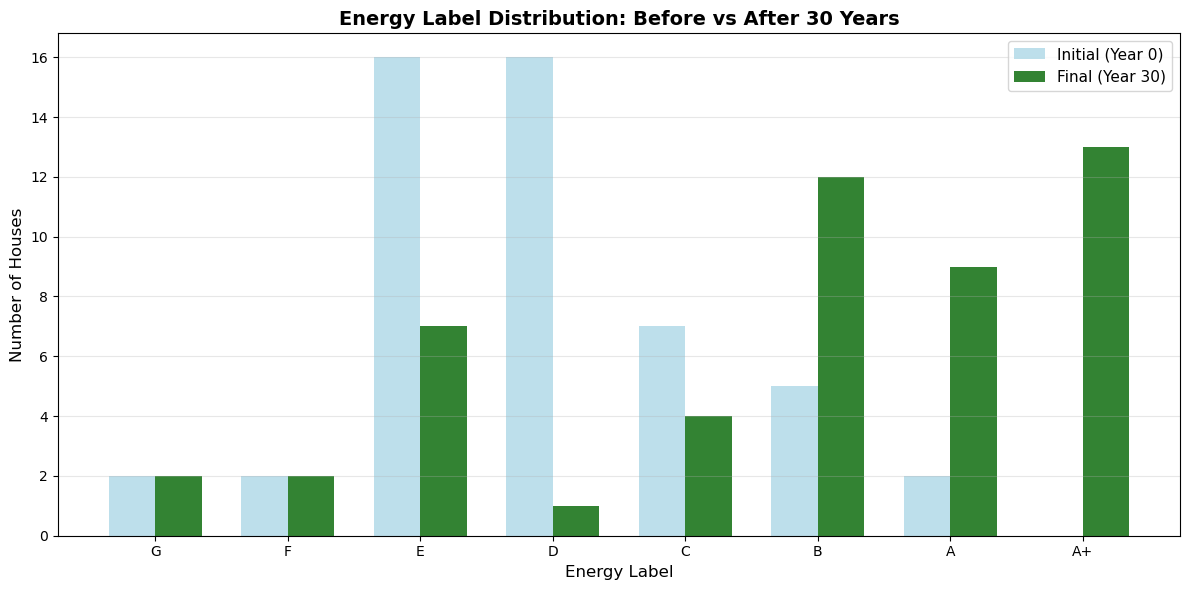


Label Distribution Changes:
--------------------------------------------------
G  :   2 →   2  (change:  +0)
F  :   2 →   2  (change:  +0)
E  :  16 →   7  (change:  -9)
D  :  16 →   1  (change: -15)
C  :   7 →   4  (change:  -3)
B  :   5 →  12  (change:  +7)
A  :   2 →   9  (change:  +7)
A+ :   0 →  13  (change: +13)
--------------------------------------------------


In [34]:
# Compare label distribution: initial vs final
labels = ['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A+']

# Use the initial counts we stored when the model was first created
initial_counts = {label: initial_label_counts.get(label, 0) for label in labels}

# Final counts (actual counts from simulation)
# Count ALL houses (both occupied and vacant) for fair comparison
all_houses = model.agents_by_type[House]
final_counts = {label: 0 for label in labels}
for house in all_houses:
    final_counts[house.current_label] += 1

# Create bar chart comparing initial vs final distributions
x = np.arange(len(labels))  # Label positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(12, 6))
# Initial distribution bars
bars1 = ax.bar(x - width/2, [initial_counts.get(l, 0) for l in labels], 
               width, label='Initial (Year 0)', alpha=0.8, color='lightblue')
# Final distribution bars
bars2 = ax.bar(x + width/2, [final_counts[l] for l in labels], 
               width, label='Final (Year 30)', alpha=0.8, color='darkgreen')

ax.set_xlabel('Energy Label', fontsize=12)
ax.set_ylabel('Number of Houses', fontsize=12)
ax.set_title('Energy Label Distribution: Before vs After 30 Years', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics showing the change for each label
print("\nLabel Distribution Changes:")
print("-" * 50)
for label in labels:
    initial = initial_counts.get(label, 0)
    final = final_counts[label]
    change = final - initial
    print(f"{label:3s}: {initial:3d} → {final:3d}  (change: {change:+3d})")
print("-" * 50)

#### Grid-based animation of house occupancy and energy labels over time  

Creating new model for animation...
Running simulation and collecting grid states for 30 years...
  Collected state for year 10
  Collected state for year 20
  Collected state for year 30
Collected 31 grid states

Creating animation (this may take 1-2 minutes)...

✓ Animation complete!
  Time taken: 20.2 seconds
  Total frames: 31 (years 0-30)
  Frame interval: 300ms (~3 frames per second)


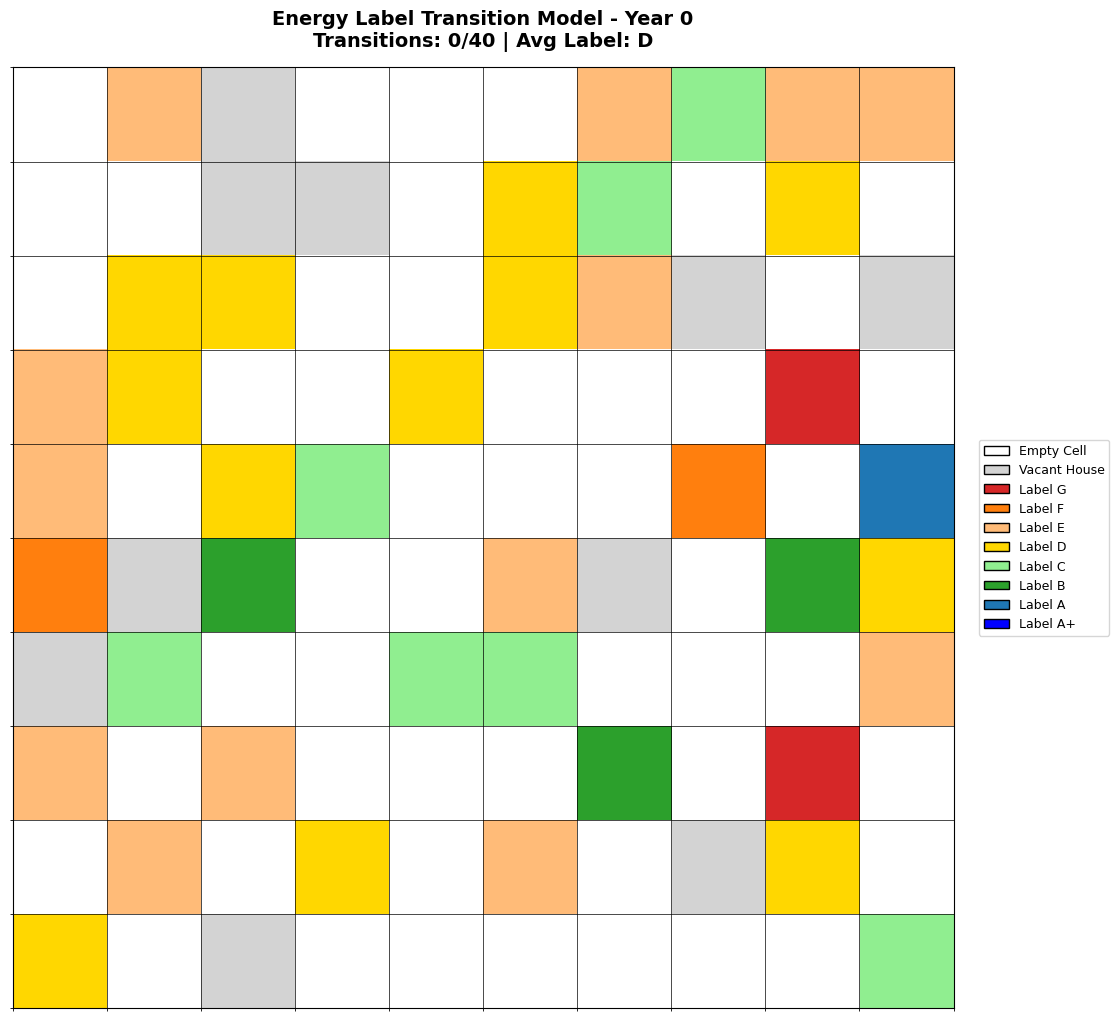

In [35]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
import matplotlib

# Increase the limit for embedding animations in notebooks
matplotlib.rcParams['animation.embed_limit'] = 2**128

start_time = time.time()

# Create a new model to run and animate
print("Creating new model for animation...")
animation_model = City(
    num_houses=50,
    num_owners=40,
    grid_size=10,
    financial_status_mean=30000,
    financial_status_std=5000,
    seed=42
)

# Store states for all 30 years (including year 0)
print("Running simulation and collecting grid states for 30 years...")
grid_states = []
stats_over_time = []

# Collect initial state (year 0)
# Use Mesa's agents_by_type to filter houses
houses = list(animation_model.agents_by_type[House])
# Create empty grid filled with -1 (represents empty cells)
grid_viz = np.full((animation_model.grid_size, animation_model.grid_size), -1.0)

# Fill grid with house information
for house in houses:
    x, y = house.pos
    if house.owner_id is None:
        grid_viz[y, x] = -0.5  # Vacant house (no owner)
    else:
        grid_viz[y, x] = label_to_numeric(house.current_label)  # Store label as number

# Store initial grid state and statistics
grid_states.append(grid_viz.copy())
stats_over_time.append({
    'year': 0,
    'transitions': animation_model.count_transitions(),
    'avg_label': animation_model.get_current_avg_label()
})

# Run simulation and collect states for each year
for year in range(1, 31):
    animation_model.step()  # Advance simulation one year
    
    # Update grid state for this year
    # Use Mesa's agents_by_type for filtering
    houses = list(animation_model.agents_by_type[House])
    grid_viz = np.full((animation_model.grid_size, animation_model.grid_size), -1.0)
    
    # Fill grid with current house information
    for house in houses:
        x, y = house.pos
        if house.owner_id is None:
            grid_viz[y, x] = -0.5  # Vacant house
        else:
            grid_viz[y, x] = label_to_numeric(house.current_label)  # Current label
    
    # Store this year's grid state and statistics
    grid_states.append(grid_viz.copy())
    stats_over_time.append({
        'year': year,
        'transitions': animation_model.count_transitions(),
        'avg_label': animation_model.get_current_avg_label()
    })
    
    # Print progress every 10 years
    if year % 10 == 0:
        print(f"  Collected state for year {year}")

print(f"Collected {len(grid_states)} grid states")
print("\nCreating animation (this may take 1-2 minutes)...")

# Create figure for animation
fig, ax = plt.subplots(figsize=(12, 10))
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Define colors and colormap
# White=empty, LightGray=vacant, then G(red) → F → E → D → C → B → A → A+(blue)
colors = ['white', 'lightgray', '#d62728', '#ff7f0e', '#ffbb78', '#ffd700', 
          '#90ee90', '#2ca02c', '#1f77b4', '#0000ff']
cmap = ListedColormap(colors)

# Create legend elements
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Empty Cell'),
    Patch(facecolor='lightgray', edgecolor='black', label='Vacant House'),
    Patch(facecolor='#d62728', edgecolor='black', label='Label G'),
    Patch(facecolor='#ff7f0e', edgecolor='black', label='Label F'),
    Patch(facecolor='#ffbb78', edgecolor='black', label='Label E'),
    Patch(facecolor='#ffd700', edgecolor='black', label='Label D'),
    Patch(facecolor='#90ee90', edgecolor='black', label='Label C'),
    Patch(facecolor='#2ca02c', edgecolor='black', label='Label B'),
    Patch(facecolor='#1f77b4', edgecolor='black', label='Label A'),
    Patch(facecolor='#0000ff', edgecolor='black', label='Label A+')
]

# Function to plot grid at each frame of animation
def plot_grid(frame):
    ax.clear()  # Clear previous frame
    
    # Get grid state and stats for this frame (year)
    grid_data = grid_states[frame]
    stats = stats_over_time[frame]
    
    # Map values for colormap: -1→0 (empty), -0.5→1 (vacant), 0-7→2-9 (labels G-A+)
    display_grid = np.where(grid_data == -1, 0,
                   np.where(grid_data == -0.5, 1, grid_data + 2))
    
    # Display grid with colors
    im = ax.imshow(display_grid, cmap=cmap, vmin=0, vmax=9, origin='lower')
    
    # Add grid lines between cells
    ax.set_xticks(np.arange(-0.5, animation_model.grid_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, animation_model.grid_size, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.set_xticks([])  # Hide axis tick labels
    ax.set_yticks([])
    
    # Add legend showing what each color means
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5), 
              fontsize=9, frameon=True)
    
    # Title with year and statistics
    ax.set_title(
        f'Energy Label Transition Model - Year {stats["year"]}\n'
        f'Transitions: {stats["transitions"]}/{animation_model.num_owners} | '
        f'Avg Label: {stats["avg_label"]}',
        fontsize=14, fontweight='bold', pad=15
    )

# Initial plot (frame 0)
plot_grid(0)

# Update function for animation - called for each frame
def update(frame):
    plot_grid(frame)

# Create animation (31 frames for years 0-30)
anim = FuncAnimation(fig, update, frames=31, repeat=True, interval=300)

# Convert to HTML for display in notebook
output = HTML(anim.to_jshtml())

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n✓ Animation complete!")
print(f"  Time taken: {elapsed_time:.1f} seconds")
print(f"  Total frames: 31 (years 0-30)")
print(f"  Frame interval: 300ms (~3 frames per second)")

# Display the animation
output

#### Batch experiments exploring the effect of financial status on transitions and average labels, including error-bar visualizations

In [36]:
from mesa.batchrunner import batch_run

print("="*70)
print("BATCHRUNNER: Effect of Financial Status on Transitions")
print("="*70)
print("\nTesting 3 financial status levels with 3 runs each...")
print("This will take about 30 seconds...\n")

# Fixed parameters
fixed_params = {
    "num_houses": 50,
    "num_owners": 40,
    "grid_size": 10,
    "financial_status_std": 10000
}

# Variable parameters (test 3 levels of financial capacity)
variable_params = {
    "financial_status_mean": [30000, 50000, 70000]
}

# Run batch experiments
results = batch_run(
    City,
    parameters={**fixed_params, **variable_params},
    iterations=3,              # 3 replications per configuration
    max_steps=30,              # 30 years per simulation
    number_processes=1,
    data_collection_period=1,
    display_progress=True
)

results_df = pd.DataFrame(results)
print("\n✓ Batch run complete!")
print(f"Total simulations run: {len(results_df['RunId'].unique())}")
print(f"Total rows collected: {len(results_df)}")

BATCHRUNNER: Effect of Financial Status on Transitions

Testing 3 financial status levels with 3 runs each...
This will take about 30 seconds...



  0%|          | 0/9 [00:00<?, ?it/s]


✓ Batch run complete!
Total simulations run: 9
Total rows collected: 25110


In [37]:
# Display batch results
results_df

,RunId,iteration,Step,num_houses,num_owners,grid_size,financial_status_std,financial_status_mean,Num_Transitioned,Num_Movings,...,Avg_Label,AgentID,Agent_Type,Financial_Status,Has_Transitioned,Has_Moved,Has_Moved_and_Transitioned,Neighbour_chillness,Owner_House_Label,House_Label
0,0,0,0,50,40,10,10000,30000,0,0,...,D,1,House,NaN,NaN,NaN,NaN,NaN,None,B
1,0,0,0,50,40,10,10000,30000,0,0,...,D,2,House,NaN,NaN,NaN,NaN,NaN,None,C
2,0,0,0,50,40,10,10000,30000,0,0,...,D,3,House,NaN,NaN,NaN,NaN,NaN,None,G
3,0,0,0,50,40,10,10000,30000,0,0,...,D,4,House,NaN,NaN,NaN,NaN,NaN,None,G
4,0,0,0,50,40,10,10000,30000,0,0,...,D,5,House,NaN,NaN,NaN,NaN,NaN,None,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25105,8,2,30,50,40,10,10000,70000,18,0,...,A+,86,Owner,11436.493415,0.0,0.0,1.0,0.050691,A+,None
25106,8,2,30,50,40,10,10000,70000,18,0,...,A+,87,Owner,61089.634302,0.0,0.0,1.0,-0.005679,A+,None
25107,8,2,30,50,40,10,10000,70000,18,0,...,A+,88,Owner,37701.932725,1.0,0.0,0.0,-0.109420,A+,None
25108,8,2,30,50,40,10,10000,70000,18,0,...,A+,89,Owner,9539.353943,0.0,0.0,1.0,0.075627,A+,None


In [38]:
# Analyze final results (year 30 only)
final_results = results_df[results_df['Step'] == 29].copy()  # Step 29 = year 30

# Calculate summary statistics grouped by financial status level
summary = final_results.groupby('financial_status_mean').agg({
    'Num_Transitioned': ['mean', 'std'],  # Average and std dev of transitions
    'Num_Movings': ['mean', 'std'],
    'Num_Moving_and_Transitioned': ['mean', 'std'],
    'Avg_Label_Numeric': ['mean', 'std']   # Average and std dev of labels
}).round(2)

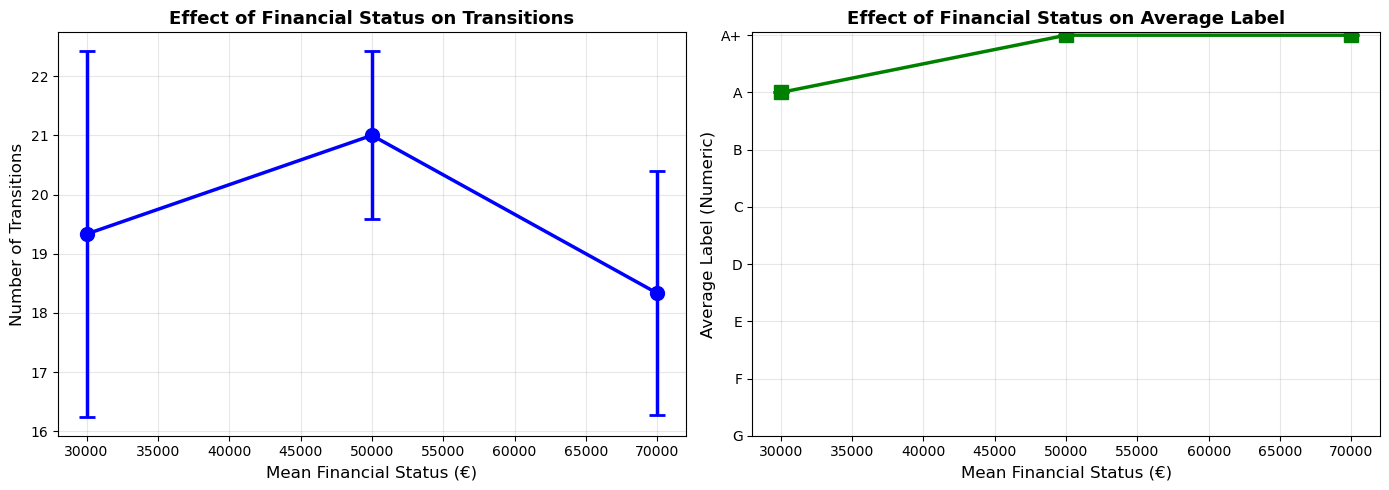

In [47]:
# Visualize batch results with error bars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get the three financial status levels tested
financial_levels = sorted(final_results['financial_status_mean'].unique())

# Calculate means and standard deviations for transitions
transition_means = [final_results[final_results['financial_status_mean']==f]['Num_Transitioned'].mean() 
                   for f in financial_levels]
transition_stds = [final_results[final_results['financial_status_mean']==f]['Num_Transitioned'].std() 
                  for f in financial_levels]

# Plot 1: Transitions by financial status with error bars
axes[0].errorbar(financial_levels, transition_means, yerr=transition_stds,
                marker='o', linewidth=2.5, markersize=10, color='blue', 
                capsize=6, capthick=2)
axes[0].set_xlabel('Mean Financial Status (€)', fontsize=12)
axes[0].set_ylabel('Number of Transitions', fontsize=12)
axes[0].set_title('Effect of Financial Status on Transitions', 
                 fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Calculate means and standard deviations for labels
label_means = [final_results[final_results['financial_status_mean']==f]['Avg_Label_Numeric'].mean() 
              for f in financial_levels]
label_stds = [final_results[final_results['financial_status_mean']==f]['Avg_Label_Numeric'].std() 
             for f in financial_levels]

# Plot 2: Average label by financial status with error bars
axes[1].errorbar(financial_levels, label_means, yerr=label_stds,
                marker='s', linewidth=2.5, markersize=10, color='green',
                capsize=6, capthick=2)
axes[1].set_xlabel('Mean Financial Status (€)', fontsize=12)
axes[1].set_ylabel('Average Label (Numeric)', fontsize=12)
axes[1].set_title('Effect of Financial Status on Average Label', 
                 fontsize=13, fontweight='bold')
# Convert y-axis to show letter labels
axes[1].set_yticks(range(8))
axes[1].set_yticklabels(['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A+'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Verification

This section performs **trace validation and invariant checks** to ensure the model behaves as expected.  

It includes:  
- A small controlled test following a single owner to verify optimal upgrade behavior.  
- Helper functions to run multiple years and check logical invariants, such as:  
  - Each house has at most one owner.  
  - `House.owner_id` and `Owner.house` are consistently linked.  
  - DataCollector counts match agent-level sums.  
- Running the verification on a larger model for multiple years to confirm consistency.  


In [48]:
# === TRACE VALIDATION: SINGLE OWNER UPGRADE ===

def test_trace_single_owner_upgrade():
    """
    Trace validation: follow a single owner in a tiny model world
    to check they upgrade when it is clearly optimal.
    """
    
    print("\n=== Trace validation: single owner upgrade ===")

    # --- Create tiny, deterministic model ---
    model = City(
        num_houses=2,
        num_owners=1,
        grid_size=2,
        financial_status_mean=50000,  # enough money to upgrade
        financial_status_std=0,
        seed=1
    )

    owner = list(model.agents_by_type[Owner])[0]
    house = owner.house

    # --- Force clear upgrade scenario ---
    house.current_label = "E"
    house.market_value = 5.0
    owner.energy_label_pref = 1.0
    owner.market_value_pref = 0.0

    print(f"Initial label: {house.current_label}")
    print(f"Initial financial_status: {owner.financial_status:.0f}")

    initial_label = house.current_label

    # --- Run one step ---
    model.step()

    new_label = house.current_label
    print(f"Label after 1 step: {new_label}")
    print(f"Has_transitioned: {owner.has_transitioned}")

    # --- Check that upgrade occurred ---
    assert label_to_numeric(new_label) > label_to_numeric(initial_label), \
        "Owner should upgrade to a better energy label."
    assert owner.has_transitioned == 1, \
        "Owner's has_transitioned should be 1 after upgrading."

    print("✅ Trace validation passed.")

# Run the test
test_trace_single_owner_upgrade()



=== Trace validation: single owner upgrade ===
Initial label: E
Initial financial_status: 50000
Label after 1 step: A+
Has_transitioned: 1
✅ Trace validation passed.


In [50]:
# === RUN MODEL AND CHECK INVARIANTS ===

def run_years(model, n_years):
    """Advance the model by n_years steps."""
    for _ in range(n_years):
        model.step()


def check_invariants(model):
    """
    Verify key logical invariants in the model:
    1. Each house has at most one owner.
    2. House.owner_id and Owner.house are consistent.
    3. DataCollector counters match agent-level sums.
    """
    houses = list(model.agents_by_type[House])
    owners = list(model.agents_by_type[Owner])

    # --- (1) Each house has at most one owner ---
    from collections import Counter
    owner_house_ids = [o.house.unique_id for o in owners if o.house is not None]
    counts_per_house = Counter(owner_house_ids)
    for house_id, c in counts_per_house.items():
        assert c == 1, f"House {house_id} has {c} owners (should be 1)."

    # --- (2) House.owner_id matches Owner.house.unique_id ---
    for h in houses:
        if h.owner_id is not None:
            linked_owners = [o for o in owners if o.unique_id == h.owner_id]
            assert len(linked_owners) == 1, f"House {h.unique_id} owner_id mismatch."
            assert linked_owners[0].house is h, "Owner.house does not point back to this house."

    # --- (3) DataCollector counters vs agent sums ---
    last_row = model.datacollector.get_model_vars_dataframe().iloc[-1]
    assert last_row["Num_Transitioned"] == sum(o.has_transitioned for o in owners)
    assert last_row["Num_Movings"] == sum(o.has_moved for o in owners)
    assert last_row["Num_Moving_and_Transitioned"] == sum(o.has_moved_and_transitioned for o in owners)


# --- Create model ---
model = City(
    num_houses=50,
    num_owners=40,
    grid_size=10,
    financial_status_mean=30000,
    financial_status_std=5000,
    seed=42
)

# --- Run model and check invariants each year ---
n_years = 20
for year in range(n_years):
    model.step()
    check_invariants(model)
    print(f"Year {year+1}: invariants OK")

print("✅ All logic / invariant checks passed.")


Year 1: invariants OK
Year 2: invariants OK
Year 3: invariants OK
Year 4: invariants OK
Year 5: invariants OK
Year 6: invariants OK
Year 7: invariants OK
Year 8: invariants OK
Year 9: invariants OK
Year 10: invariants OK
Year 11: invariants OK
Year 12: invariants OK
Year 13: invariants OK
Year 14: invariants OK
Year 15: invariants OK
Year 16: invariants OK
Year 17: invariants OK
Year 18: invariants OK
Year 19: invariants OK
Year 20: invariants OK
✅ All logic / invariant checks passed.


### Sensitivity Analysis

This section explores the impact of **key model parameters** on outcomes through systematic batch simulations.  

It includes:  
- Running multiple **parameter combinations** (e.g., market value distribution, energy label preferences, neighbourhood importance) over 30 years.  
- Collecting final-step results and computing **summary statistics**: means, standard deviations, and quantiles for numeric and count indicators.  
- Visualizing outcomes with plots showing **median ± quantiles** for count indicators and **mean ± standard deviation** for average energy labels.  
- Ranking parameter combinations to identify **top and bottom performing scenarios**.  
- Saving the resulting figure and comparing top vs. bottom combinations in terms of **average energy label performance**.


In [51]:
# === SENSITIVITY ANALYSES ===

print("="*70)
print("Sensitivity Analyses")
print("="*70)
print("\nTesting multiple parameters... This may take a while.\n")

# --- Define parameters to test ---
variable_params = {
    "market_value_distribution": [(0.8, 0.2), (0.6, 0.4), (0.5, 0.5), (0.4, 0.6), (0.2, 0.8)],
    "average_energy_label_preference": [0.2, 0.4, 0.5, 0.6, 0.8],
    "variance_energy_label_preference": [0.1, 0.2, 0.3, 0.4],
    "importance_of_neighbours": [0.5, 1.0, 2.0, 4.0, 8.0]
}

# --- Run batch experiments in smaller chunks for safety ---
dfs = []
total_iterations = 100
iteration_chunk = 10  # number of iterations per batch

for i in range(0, total_iterations, iteration_chunk):
    print(f"\nRunning iterations {i+1}–{i+iteration_chunk}...")

    # Run batch with Mesa
    sensitivity_results = batch_run(
        City,
        parameters=variable_params,       # all combinations of these variables
        iterations=iteration_chunk,
        max_steps=30,                      # simulate 30 years
        number_processes=1,
        data_collection_period=30,         # collect data only at final step
        display_progress=True
    )

    # Store results as DataFrame
    df = pd.DataFrame(sensitivity_results)
    dfs.append(df)

    # Free memory
    del sensitivity_results
    gc.collect()

# --- Combine all results into one DataFrame ---
sensitivity_results_df = pd.concat(dfs, ignore_index=True)

print("\n✓ Batch run complete!")
print(f"Total simulations run: {sensitivity_results_df['RunId'].nunique()}")
print(f"Total rows collected: {len(sensitivity_results_df)}")


Sensitivity Analyses

Testing multiple parameters... This may take a while.


Running iterations 1–10...


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Analyze final results
final_sensitivity_results = sensitivity_results_df[sensitivity_results_df['Step'] == 30].copy()
final_sensitivity_results

,RunId,iteration,Step,market_value_distribution,average_energy_label_preference,variance_energy_label_preference,importance_of_neighbours,Num_Transitioned,Num_Movings,Num_Moving_and_Transitioned,...,Avg_Label,AgentID,Agent_Type,Financial_Status,Has_Transitioned,Has_Moved,Has_Moved_and_Transitioned,Neighbour_chillness,Owner_House_Label,House_Label
90,0,0,30,"(0.8, 0.2)",0.2,0.1,0.5,20,3,17,...,B,1,House,NaN,NaN,NaN,NaN,NaN,None,F
91,0,0,30,"(0.8, 0.2)",0.2,0.1,0.5,20,3,17,...,B,2,House,NaN,NaN,NaN,NaN,NaN,None,B
92,0,0,30,"(0.8, 0.2)",0.2,0.1,0.5,20,3,17,...,B,3,House,NaN,NaN,NaN,NaN,NaN,None,A+
93,0,0,30,"(0.8, 0.2)",0.2,0.1,0.5,20,3,17,...,B,4,House,NaN,NaN,NaN,NaN,NaN,None,B
94,0,0,30,"(0.8, 0.2)",0.2,0.1,0.5,20,3,17,...,B,5,House,NaN,NaN,NaN,NaN,NaN,None,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999995,4999,9,30,"(0.2, 0.8)",0.8,0.4,8.0,9,74,38,...,B,86,Owner,6409.122449,0.0,6.0,0.0,-0.207394,A+,None
8999996,4999,9,30,"(0.2, 0.8)",0.8,0.4,8.0,9,74,38,...,B,87,Owner,63.195840,0.0,0.0,1.0,-0.179584,A,None
8999997,4999,9,30,"(0.2, 0.8)",0.8,0.4,8.0,9,74,38,...,B,88,Owner,4640.462525,0.0,2.0,1.0,0.082579,E,None
8999998,4999,9,30,"(0.2, 0.8)",0.8,0.4,8.0,9,74,38,...,B,89,Owner,2833.583013,0.0,0.0,1.0,-0.172448,B,None


In [52]:
# === PROCESS SENSITIVITY RESULTS ===

# Define which indicators to summarize
numeric_indicators = [
    'Num_Transitioned',
    'Num_Movings',
    'Num_Moving_and_Transitioned',
    'Avg_Label_Numeric'  # numeric representation of energy label
]

count_indicators = [
    'Num_Transitioned',
    'Num_Movings',
    'Num_Moving_and_Transitioned'
]

label_indicator = 'Avg_Label_Numeric'  # used for std deviation only
quantiles = [0.25, 0.5, 0.75]          # for count indicators

tables = []

# Loop over each parameter and summarize its effect
for param, values in variable_params.items():
    df_param = final_sensitivity_results.copy()

    # Make tuple columns hashable for grouping (if needed)
    if isinstance(values[0], tuple):
        df_param[param] = df_param[param].apply(tuple)

    # Keep only the relevant parameter values
    df_param = df_param[df_param[param].isin(values)]

    # Ensure all indicators are numeric
    df_param[numeric_indicators] = df_param[numeric_indicators].apply(
        pd.to_numeric, errors='coerce'
    )

    # --- Compute mean for all numeric indicators ---
    summary_mean = df_param.groupby(param)[numeric_indicators].mean()
    summary_mean.columns = pd.MultiIndex.from_product([summary_mean.columns, ['mean']])

    # --- Compute quantiles (25%, 50%, 75%) for count indicators ---
    summary_quantiles = df_param.groupby(param)[count_indicators].quantile(quantiles).unstack(level=-1)
    summary_quantiles.columns = [
        (indicator, f"q{int(q*100)}") for indicator, q in summary_quantiles.columns
    ]

    # --- Compute standard deviation for energy label only ---
    summary_std = df_param.groupby(param)[label_indicator].std().to_frame()
    summary_std.columns = pd.MultiIndex.from_product([[label_indicator], ['std']])

    # --- Combine mean, quantiles, and std into a single table ---
    summary = pd.concat([summary_mean, summary_quantiles, summary_std], axis=1).round(2)
    summary.index = pd.MultiIndex.from_tuples(
        [(param, str(v)) for v in summary.index],
        names=["parameter", "parameter_value"]
    )

    tables.append(summary)

# Concatenate summaries for all parameters
sensitivity_summary_df = pd.concat(tables)

# Display the final summarized table
sensitivity_summary_df


NameError: name 'final_sensitivity_results' is not defined

Figure saved to: C:\Users\jarnosoos\OneDrive - Universiteit Leiden\Year 2\ABM\sensitivity_analysis_figure.png


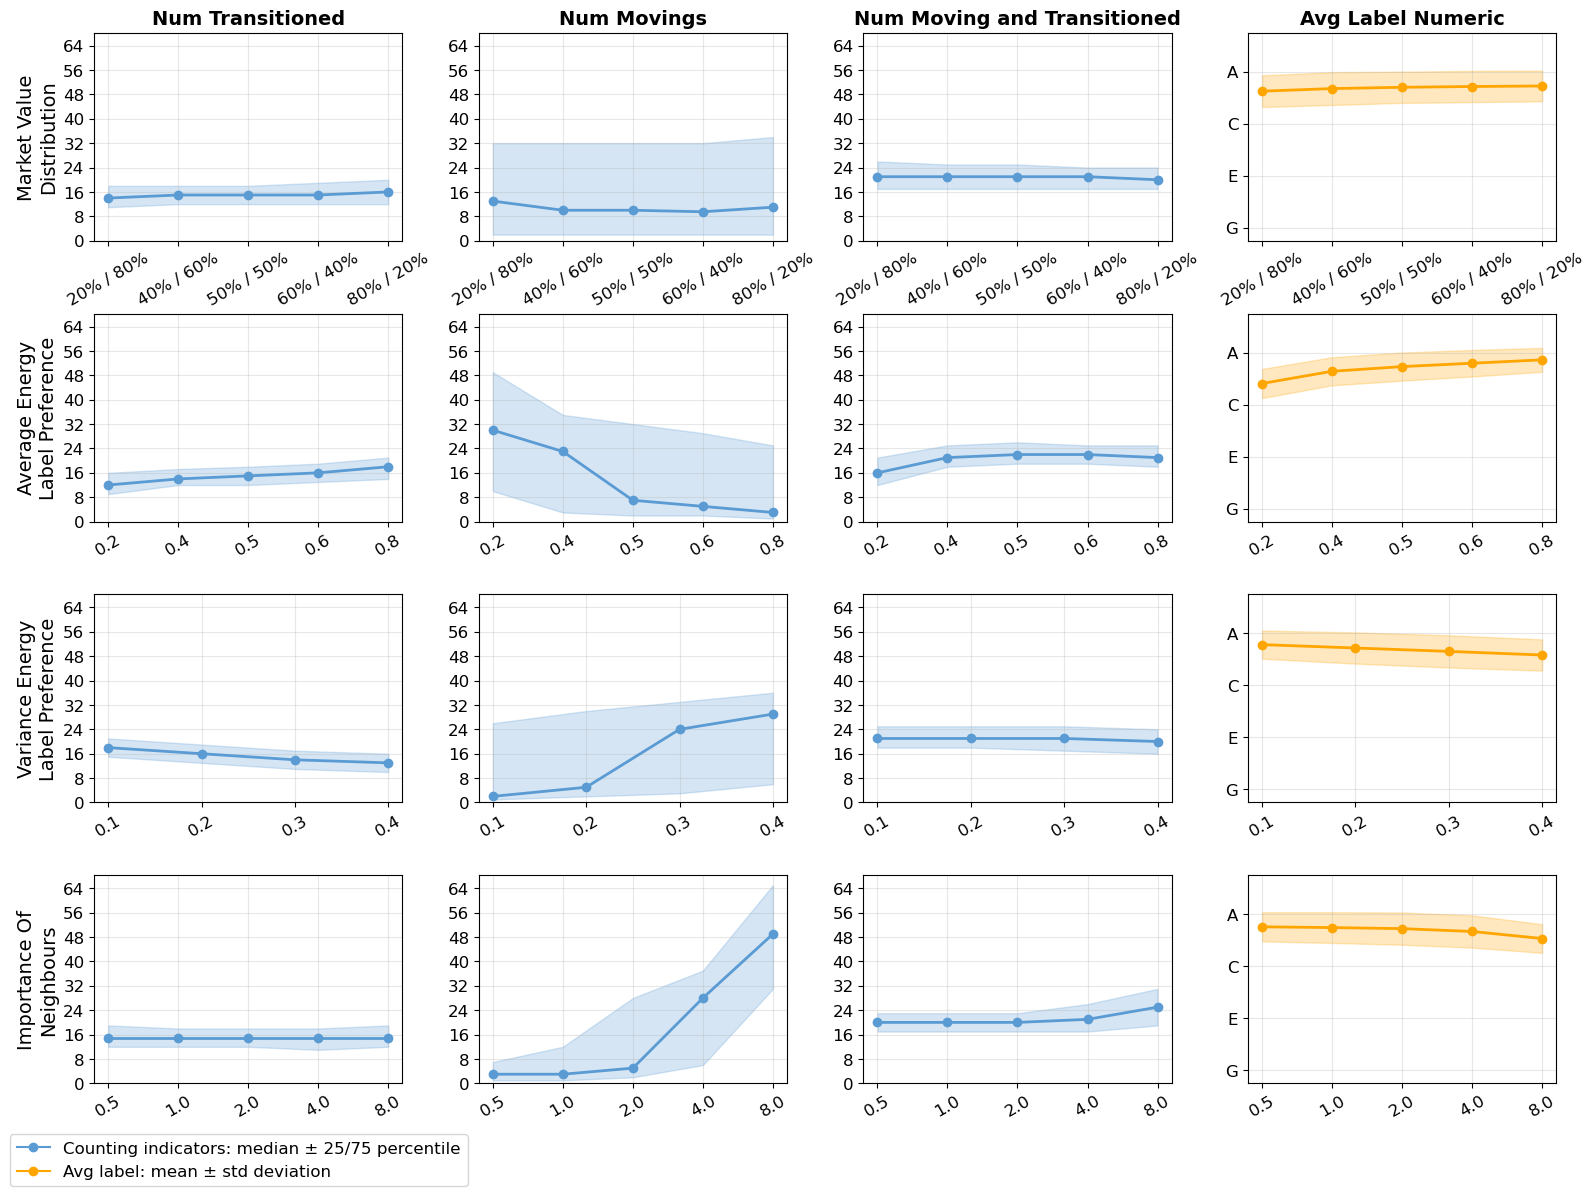

In [ ]:
# === PLOT SENSITIVITY RESULTS ===

# Extract parameter names and indicators from the summarized dataframe
parameters = sensitivity_summary_df.index.get_level_values('parameter').unique()
indicators = sensitivity_summary_df.columns.get_level_values(0).unique()

# Indicators that share the same y-axis scale
count_indicators = [
    'Num_Transitioned',
    'Num_Movings',
    'Num_Moving_and_Transitioned'
]

# --------------------------------------------------
# Compute global max for count indicators (for consistent y-axis scaling)
# --------------------------------------------------
global_max = 0
for param in parameters:
    df_param = sensitivity_summary_df.loc[param]
    for indicator in count_indicators:
        if indicator in indicators:
            q75 = df_param[(indicator, 'q75')].values
            global_max = max(global_max, np.nanmax(q75))
# Add 5% headroom
global_max *= 1.05

# --------------------------------------------------
# Set up figure grid
# --------------------------------------------------
n_rows = len(parameters)
n_cols = len(indicators)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=False)

# Ensure axes is 2D for consistent indexing
if n_rows == 1:
    axes = np.array([axes])
if n_cols == 1:
    axes = axes[:, np.newaxis]

# --------------------------------------------------
# Plot each indicator per parameter
# --------------------------------------------------
for i, param in enumerate(parameters):
    df_param = sensitivity_summary_df.loc[param]

    # Format y-axis label with optional line break
    y_label = param.replace('_', ' ').title()
    space_indices = [idx for idx, char in enumerate(y_label) if char == ' ']
    if len(space_indices) >= 2:
        second_space_idx = space_indices[1]
        y_label_wrapped = y_label[:second_space_idx] + '\n' + y_label[second_space_idx+1:]
    else:
        y_label_wrapped = y_label

    # Prepare x-axis labels
    try:
        x_numeric = df_param.index.astype(float)
        sort_idx = np.argsort(x_numeric)
        x_labels = [str(x_numeric[idx]) for idx in sort_idx]
    except ValueError:
        sort_idx = range(len(df_param.index))
        def format_tuple_label(s):
            a, b = s.strip('()').split(',')
            return f"{int(float(a)*100)}% / {int(float(b)*100)}%"
        x_labels = [format_tuple_label(v) for v in df_param.index]

    for j, indicator in enumerate(indicators):
        ax = axes[i, j]
        x = np.arange(len(sort_idx))

        if indicator in count_indicators:
            # Plot median ± 25/75 percentile
            center = df_param[(indicator, 'q50')].values[list(sort_idx)]
            lower = df_param[(indicator, 'q25')].values[list(sort_idx)]
            upper = df_param[(indicator, 'q75')].values[list(sort_idx)]

            ax.plot(x, center, marker='o', linewidth=2, color='#5a9bd4')
            ax.fill_between(x, lower, upper, alpha=0.25, color='#5a9bd4')
            ax.set_ylim(0, global_max)
            ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

        elif indicator == 'Avg_Label_Numeric':
            # Plot mean ± std deviation
            mean = df_param[(indicator, 'mean')].values[list(sort_idx)]
            std = df_param[(indicator, 'std')].values[list(sort_idx)]

            ax.plot(x, mean, marker='o', linewidth=2, color='orange')
            ax.fill_between(x, mean - std, mean + std, alpha=0.25, color='orange')
            ax.set_ylim(-0.5, 7.5)

            # Format y-axis as energy labels
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: numeric_to_label(round(y))))

        # Titles and labels
        if i == 0:
            ax.set_title(indicator.replace('_', ' '), fontsize=14, fontweight='bold')
        if j == 0:
            ax.set_ylabel(y_label_wrapped, fontsize=14)

        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=30, fontsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.grid(True, alpha=0.3)

# --------------------------------------------------
# Add a single legend for the whole figure
# --------------------------------------------------
median_patch = mlines.Line2D([], [], color='#5a9bd4', marker='o', linestyle='-',
                             label='Counting indicators: median ± 25/75 percentile')
label_patch = mlines.Line2D([], [], color='orange', marker='o', linestyle='-',
                            label='Avg label: mean ± std deviation')

fig.legend(handles=[median_patch, label_patch],
           loc='lower left', bbox_to_anchor=(0, 0), fontsize=12)

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.subplots_adjust(hspace=0.35)

# --------------------------------------------------
# Save figure
# --------------------------------------------------
output_path = r"C:\Users\jarnosoos\OneDrive - Universiteit Leiden\Year 2\ABM\sensitivity_analysis_figure.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {output_path}")

plt.show()


In [53]:
# === TOP/BOTTOM PARAMETER COMBINATION ANALYSIS ===

# List of parameters used in the sensitivity analysis
parameter_cols = list(variable_params.keys())

# --------------------------------------------------
# Compute mean and std of average energy label per parameter combination
# --------------------------------------------------
ranking_df = (
    final_sensitivity_results
    .groupby(parameter_cols)
    .agg(
        Avg_Label_Mean=('Avg_Label_Numeric', 'mean'),  # mean across runs
        Avg_Label_Std=('Avg_Label_Numeric', 'std')     # standard deviation
    )
    .reset_index()
    .sort_values('Avg_Label_Mean', ascending=False)    # rank by highest mean label
    .reset_index(drop=True)
)

# Add explicit rank column
ranking_df['Rank'] = ranking_df.index + 1

# --------------------------------------------------
# Select top and bottom N parameter combinations
# --------------------------------------------------
N = 10  # number of combinations to consider for top/bottom

top_df = ranking_df.head(N)
bottom_df = ranking_df.tail(N)

# --------------------------------------------------
# Helper function: summarize parameters per dataframe
# - For numeric parameters: take median
# - For tuple parameters (e.g., distributions): take mode
# --------------------------------------------------
def summarize_params_numeric(df):
    summary = {}
    for param in parameter_cols:
        if isinstance(df[param].iloc[0], tuple):
            summary[param] = df[param].mode().iloc[0]
        else:
            summary[param] = df[param].median()
    return summary

# Create a contrast table summarizing top vs bottom combinations
contrast_df = pd.DataFrame({
    'Top combinations (median / mode)': summarize_params_numeric(top_df),
    'Bottom combinations (median / mode)': summarize_params_numeric(bottom_df)
})

contrast_df  # display results


NameError: name 'final_sensitivity_results' is not defined

In [54]:
# === SUMMARY OF TOP VS BOTTOM PARAMETER COMBINATIONS ===

# Compare overall performance of top vs bottom combinations
# Metrics: mean and standard deviation of Avg_Label_Mean across the selected combinations

outcome_comparison = pd.DataFrame({
    'Top combinations': {
        'Avg energy label (mean)': top_df['Avg_Label_Mean'].mean(),   # mean across top N combinations
        'Std across combinations': top_df['Avg_Label_Mean'].std()     # variability across top N
    },
    'Bottom combinations': {
        'Avg energy label (mean)': bottom_df['Avg_Label_Mean'].mean(), # mean across bottom N combinations
        'Std across combinations': bottom_df['Avg_Label_Mean'].std()   # variability across bottom N
    }
}).round(3)  # round for readability

outcome_comparison  # display results


NameError: name 'top_df' is not defined

# Experimental Design: Mini-Batch Run

This section implements a **mini-batch experimental design** to explore the effects of selected model parameters on simulation outcomes.

Key components:

1. **Factorial Experiment (4 scenarios)**  
   - Vary `average_energy_label_preference` and `importance_of_neighbours`.  
   - 100 iterations per combination.  
   - Collect step-wise results over 30 years.

2. **Reference Scenario**  
   - Baseline parameters (`average_energy_label_preference=0.5`, `importance_of_neighbours=1.0`).  
   - Run separately with the same number of iterations for comparison.

3. **Scenario Labelling and Aggregation**  
   - Each run is assigned a descriptive scenario name (e.g., "Pure Market Logic", "Green Pragmatism").  
   - Aggregate metrics per scenario and step:  
     - **Counting indicators** (median ± interquartile range)  
     - **Average energy label** (mean ± standard deviation)

4. **Visualization**  
   - **Line plots over time**: display trends of moves, transitions, and average energy label.  
   - **Owner social cohesion vs. average house energy label**: highlights effect of neighbourhood chillness.  
   - **Energy label distribution per scenario at year 30**: grouped bar charts for comparison.

5. **Aligned and consistent styling**  
   - Shared color schemes, legends, and axis formatting across plots for easy interpretation.  
   - Provides a clear overview of how different experimental setups influence housing energy transitions.


In [55]:
# === EXPERIMENTAL DESIGN: MINI-BATCH RUN ===

print("="*70)
print("Experimental Design: Mini-Batch Run")
print("="*70)

# --------------------------------------------------
# 1. Factorial experiment: 4 parameter combinations
# --------------------------------------------------
print("\nRunning factorial experiment (4 parameter combinations)...\n")

variable_params = {
    "average_energy_label_preference": [0.2, 0.8],
    "importance_of_neighbours": [0.5, 2.0]
}

iterations_per_combination = 100
dfs = []

# Run the factorial combinations in batch
results_factorial = batch_run(
    City,
    parameters=variable_params,
    iterations=iterations_per_combination,
    max_steps=30,
    number_processes=1,
    data_collection_period=1,
    display_progress=True
)

df_factorial = pd.DataFrame(results_factorial)
df_factorial["Experiment_Type"] = "Factorial"
dfs.append(df_factorial)

del results_factorial
gc.collect()  # free memory

# --------------------------------------------------
# 2. Reference scenario: single baseline run
# --------------------------------------------------
print("\nRunning reference scenario (separate batch)...\n")

reference_params = {
    "average_energy_label_preference": 0.5,
    "importance_of_neighbours": 1.0
}

results_reference = batch_run(
    City,
    parameters=reference_params,
    iterations=iterations_per_combination,
    max_steps=30,
    number_processes=1,
    data_collection_period=1,
    display_progress=True
)

df_reference = pd.DataFrame(results_reference)
df_reference["Experiment_Type"] = "Reference"
dfs.append(df_reference)

del results_reference
gc.collect()  # free memory

# --------------------------------------------------
# 3. Combine all experimental results
# --------------------------------------------------
experimental_results_df = pd.concat(dfs, ignore_index=True)

print("\n✓ Mini-batch run complete!")
print(f"Total simulations run: {experimental_results_df['RunId'].nunique()}")
print(f"Total rows collected: {len(experimental_results_df)}")

print("\nExperiment types:")
print(experimental_results_df["Experiment_Type"].value_counts())


Experimental Design: Mini-Batch Run

Running factorial experiment (4 parameter combinations)...



  0%|          | 0/400 [00:00<?, ?it/s]


Running reference scenario (separate batch)...



  0%|          | 0/100 [00:00<?, ?it/s]


✓ Mini-batch run complete!
Total simulations run: 400
Total rows collected: 1395000

Experiment types:
Experiment_Type
Factorial    1116000
Reference     279000
Name: count, dtype: int64


In [56]:
# === SCENARIO ASSIGNMENT AND AGGREGATION ===

# --------------------------------------------------
# 0. Map indicator columns to readable labels
# --------------------------------------------------
indicator_labels = {
    'Num_Transitioned': 'Number Transitioned',
    'Num_Movings': 'Number of Moves',
    'Num_Moving_and_Transitioned': 'Number Moving & Transitioned',
    'Avg_Label_Numeric': 'Average Energy Label'
}

# --------------------------------------------------
# 1. Assign scenario labels based on parameter values
# --------------------------------------------------
def assign_scenario(row):
    pref = row['average_energy_label_preference']
    neigh = row['importance_of_neighbours']

    # Base (reference) scenario
    if pref == 0.5 and neigh == 1:
        return "S0: Base Scenario"
    # Factorial scenarios
    elif pref == 0.2 and neigh == 0.5:
        return "S1: Pure Market Logic"
    elif pref == 0.2 and neigh == 2:
        return "S2: Social Capital Housing Market"
    elif pref == 0.8 and neigh == 0.5:
        return "S3: Green Pragmatism"
    elif pref == 0.8 and neigh == 2:
        return "S4: Energy Concious Communities"
    else:
        return "Other"

# Apply scenario assignment to experimental results
experimental_results_df['Scenario'] = experimental_results_df.apply(assign_scenario, axis=1)

# Ensure proper ordering of scenarios for plotting/analysis
scenario_order = [
    "S0: Base Scenario",
    "S1: Pure Market Logic",
    "S2: Social Capital Housing Market",
    "S3: Green Pragmatism",
    "S4: Energy Concious Communities"
]
experimental_results_df["Scenario"] = pd.Categorical(
    experimental_results_df["Scenario"],
    categories=scenario_order,
    ordered=True
)

# --------------------------------------------------
# 2. Aggregate statistics per Scenario & Step
# --------------------------------------------------
# Define aggregation rules
agg_dict = {}
for ind in count_indicators:  # count-based indicators
    agg_dict[ind] = ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)]
agg_dict['Avg_Label_Numeric'] = ['mean', 'std']  # energy label indicator

# Group by Scenario and Step, compute aggregated metrics
g = experimental_results_df.groupby(['Scenario', 'Step'], observed=False).agg(agg_dict)

# Flatten MultiIndex columns for easier access
g.columns = [
    f"{col[0]}_{col[1] if isinstance(col[1], str) else col[1].__name__}"
    for col in g.columns
]

# Reset index for convenience
g = g.reset_index()


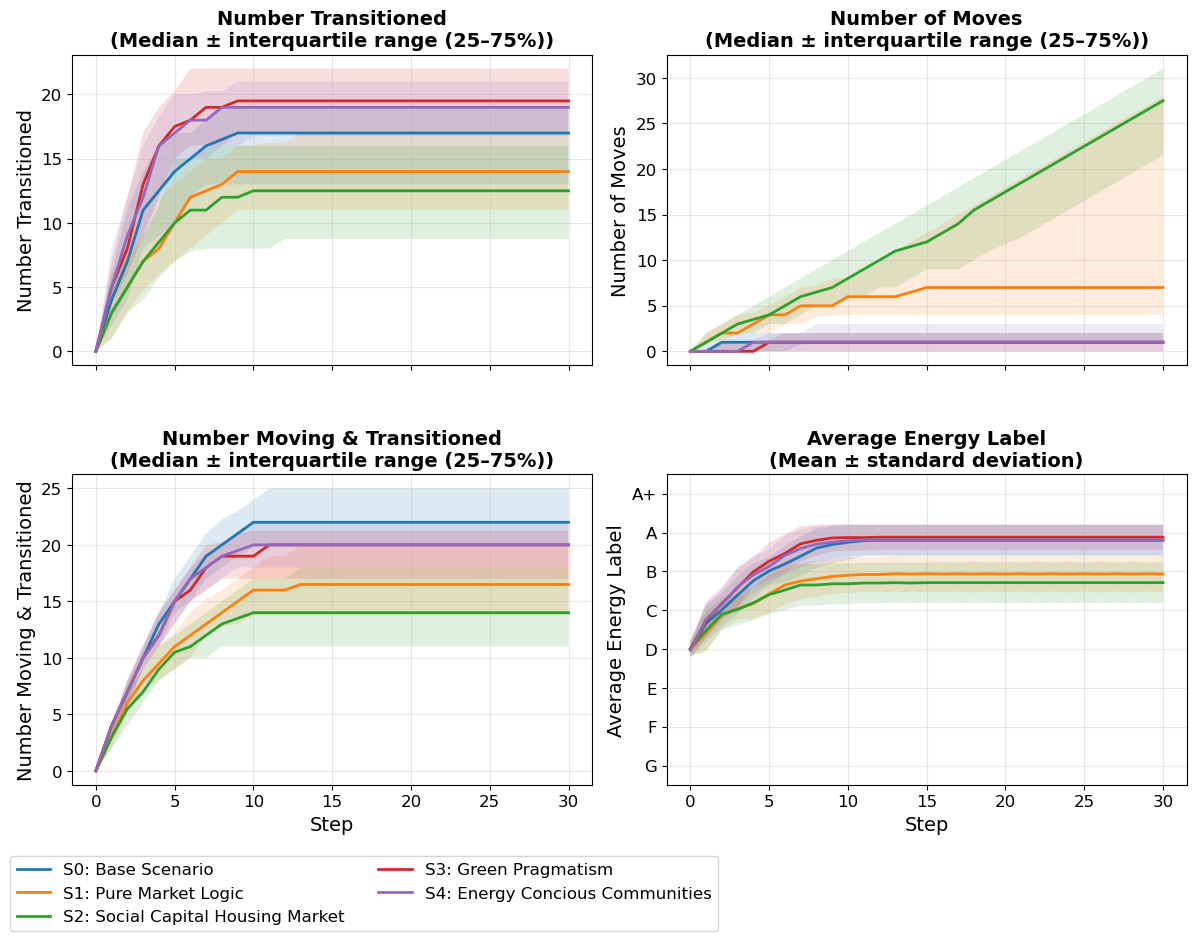

Figure saved to: C:\Users\jarnosoos\OneDrive - Universiteit Leiden\Year 2\ABM\timeseriesplot_experimental_design.png


In [60]:
# === LINE PLOTS OVER TIME (2x2 GRID) ===

# Metrics to plot: all count indicators + average energy label
metrics = count_indicators + ['Avg_Label_Numeric']

# Setup 2x2 grid of subplots
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 9), sharex=True)
axes = axes.flatten()  # flatten for easy iteration

used_labels = set()  # track labels to avoid duplicates in legend

for ax, metric in zip(axes, metrics):
    for sc in scenario_order:
        sub = g[g["Scenario"] == sc]
        if sub.empty:
            continue

        # Only label the scenario once for the legend
        label = sc if sc not in used_labels else None
        used_labels.add(sc)

        x = sub["Step"]  # simulation steps (x-axis)

        if metric in count_indicators:
            # Count indicators: plot median with interquartile range
            center = sub[f"{metric}_median"]
            lower = sub[f"{metric}_<lambda_0>"]
            upper = sub[f"{metric}_<lambda_1>"]

            ax.plot(x, center, linewidth=2, label=label)
            ax.fill_between(x, lower, upper, alpha=0.15)
            uncertainty_label = "Median ± interquartile range (25–75%)"

        else:
            # Average label: plot mean with std deviation
            mean = sub[f"{metric}_mean"]
            std = sub[f"{metric}_std"]

            ax.plot(x, mean, linewidth=2, label=label)
            ax.fill_between(x, mean - std, mean + std, alpha=0.15)
            ax.set_ylim(-0.5, 7.5)  # energy labels from G (0) to A+ (7)
            ax.yaxis.set_major_formatter(
                plt.FuncFormatter(lambda y, _: numeric_to_label(round(y)))
            )
            uncertainty_label = "Mean ± standard deviation"

        # Add light grid for readability
        ax.grid(True, alpha=0.3)

    # Titles & y-labels
    ax.set_title(f"{indicator_labels[metric]}\n({uncertainty_label})", fontsize=14, fontweight='bold')
    ax.set_ylabel(indicator_labels[metric], fontsize=14)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

# x-axis label for bottom row of plots
for ax in axes[-2:]:
    ax.set_xlabel("Step", fontsize=14)

# Single legend for all plots
fig.legend(
    loc='lower left',
    bbox_to_anchor=(0, -0.05),
    fontsize=12,
    ncol=2
)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.subplots_adjust(hspace=0.35)

# Display plots
plt.show()

# Save plots
output_path = r"C:\Users\jarnosoos\OneDrive - Universiteit Leiden\Year 2\ABM\timeseriesplot_experimental_design.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {output_path}")


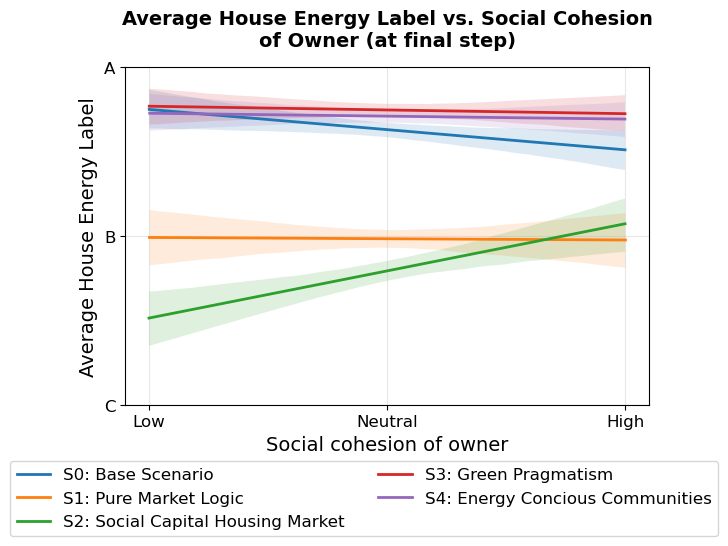

Figure saved to: C:\Users\jarnosoos\OneDrive - Universiteit Leiden\Year 2\ABM\social_cohesion_plot.png


In [61]:
# === OWNER CHILLNESS VS AVERAGE HOUSE ENERGY LABEL ===

# Keep only Owner agents at the final simulation step
owners_final = experimental_results_df[experimental_results_df['Step'] == 30].copy()

# Ensure a numeric version of the house energy label exists for plotting
if 'Owner_House_Label' in owners_final.columns:
    owners_final['Owner_House_Label_Numeric'] = owners_final['Owner_House_Label'].apply(label_to_numeric)
else:
    # Fallback if individual labels not stored: use Avg_Label_Numeric
    owners_final['Owner_House_Label_Numeric'] = owners_final['Avg_Label_Numeric']

# Create figure and axis manually (avoiding sns.lmplot) for consistent styling
fig, ax = plt.subplots(figsize=(6, 5))

# Loop through scenarios and fit a linear regression line
for sc in scenario_order:
    sub = owners_final[owners_final['Scenario'] == sc]
    if sub.empty:
        continue

    # Fit regression line (no scatter points), 95% confidence interval
    sns.regplot(
        data=sub,
        x='Neighbour_chillness',                  # x-axis: owner's social cohesion
        y='Owner_House_Label_Numeric',            # y-axis: numeric house energy label
        scatter=False,
        ci=95,
        line_kws={'linewidth': 2},
        label=sc,
        ax=ax
    )

# Dynamically set y-ticks based on displayed regression lines
line_ydata = [y for line in ax.get_lines() for y in line.get_ydata()]
y_min = int(np.floor(min(line_ydata)))
y_max = int(np.ceil(max(line_ydata)))
ax.set_yticks(range(y_min, y_max + 1))
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: numeric_to_label(int(round(y))))
)

# X-axis ticks: min, midpoint, max for clarity
x_min = owners_final['Neighbour_chillness'].min()
x_max = owners_final['Neighbour_chillness'].max()
x_mid = (x_min + x_max) / 2
ax.set_xticks([x_min, x_mid, x_max])
ax.set_xticklabels(['Low', 'Neutral', 'High'], fontsize=12)

# Labels and title
ax.set_xlabel("Social cohesion of owner", fontsize=14)
ax.set_ylabel("Average House Energy Label", fontsize=14)
ax.set_title(
    "Average House Energy Label vs. Social Cohesion\nof Owner (at final step)",
    fontsize=14, fontweight='bold', pad=15
)

# Grid and tick styling
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(True, alpha=0.3)

# Legend (centered below plot)
fig.legend(
    loc='lower center',
    ncol=2,
    fontsize=12,
    bbox_to_anchor=(0.5, -0.1)
)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Display plot
plt.show()

# Save plot
output_path = r"C:\Users\jarnosoos\OneDrive - Universiteit Leiden\Year 2\ABM\social_cohesion_plot.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {output_path}")


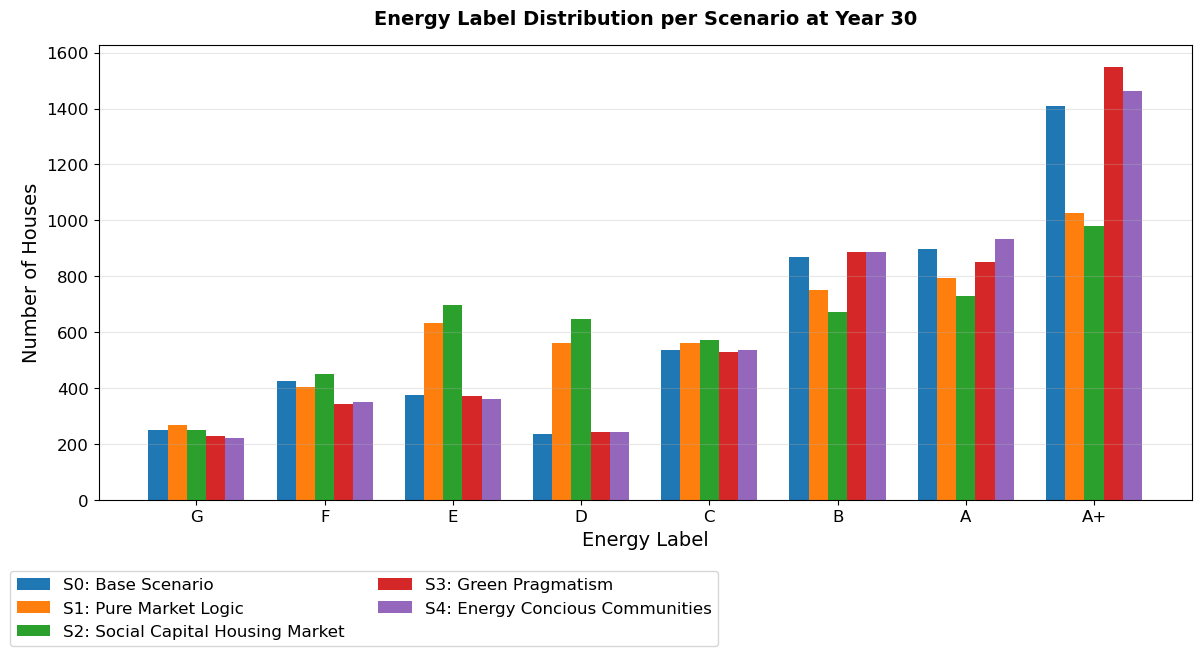

Figure saved to: C:\Users\jarnosoos\OneDrive - Universiteit Leiden\Year 2\ABM\label_distribution_plot.png


In [62]:
# === ENERGY LABEL DISTRIBUTION PER SCENARIO AT YEAR 30 ===

# Define all possible energy labels (from worst to best)
labels = ['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A+']

# Filter to keep only House agents at the final simulation step
house_final = experimental_results_df[
    (experimental_results_df['Step'] == 30) & 
    (experimental_results_df['Agent_Type'] == 'House')
].copy()

# Count the number of houses per energy label for each scenario
label_counts = (
    house_final
    .groupby(['Scenario', 'House_Label'], observed=False)
    .size()
    .unstack(fill_value=0)
    .reindex(labels, axis=1, fill_value=0)  # Ensure all labels appear, even if 0
)

# Setup grouped bar chart
scenarios = label_counts.index
x = np.arange(len(labels))  # x positions for energy labels
width = 0.15  # width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each scenario as a separate set of bars
for i, sc in enumerate(scenarios):
    counts = label_counts.loc[sc].values
    ax.bar(x + i*width - width*2, counts, width, label=sc)

# Labels, title, and grid
ax.set_xlabel('Energy Label', fontsize=14)
ax.set_ylabel('Number of Houses', fontsize=14)
ax.set_title(
    'Energy Label Distribution per Scenario at Year 30',
    fontsize=14, fontweight='bold', pad=15
)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', alpha=0.3)

# Legend (positioned below plot)
fig.legend(
    loc='lower right',
    ncol=2,
    fontsize=12,
    bbox_to_anchor=(0.6, -0.1)
)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Display the plot
plt.show()

# Save plot
output_path = r"C:\Users\jarnosoos\OneDrive - Universiteit Leiden\Year 2\ABM\label_distribution_plot.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {output_path}")